# New MANGO Level 1 Data
This tutorial demonstrates how to work with the new level 1 processed MANGO data product.  Each file contains all images from a single camera on a single night.  The level 1 data product should contain the processed images as well as any coordinates, processing information, and metadata needed for scientific analysis.  The standard processing manipulates the raw images as follows [Garcia1997]:
- Dewarped so spatial distances are true
- Rotated so the top of the image is north
- Background estimate removed


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as feature

filename = '/Users/e30737/Desktop/Projects/MANGO/mango-l1.hdf5'

## Data Fields

### ImageData
The main image data are contained in the `ImageData` field, which is a Nrecords x 500 x 500 array containing all images for the night.

In [2]:
with h5py.File(filename, 'r') as h5:
    image = h5['ImageData'][:]
print(image.shape)

(305, 500, 500)


### UnixTime
Time is contained in the `UnixTime` field, which is a Nrecords x 2 array.  The array contains both the start time and end time of individual exposures.  To assign each record a single time stamp, it is acceptable to just take the first element of this array representing the start time of each exposure.  Time is saved in unix time, or seconds since January 1, 1970.  A variety of modules can convert this to a datetime object (ie, datetime, numpy, pandas, astropy), the example below shows one simple method.

In [3]:
with h5py.File(filename, 'r') as h5:
    utime = h5['UnixTime'][:]
print(utime.shape)

# Convert utime array to useful timestamps
time = utime[:,0].astype('datetime64[s]')


(305, 2)


### SiteInfo
The `SiteInfo` group contains various information about the camera and site.  Things like site coordinates are often needed for analysis or compairing against other instruments.

In [4]:
with h5py.File(filename, 'r') as h5:
    print('Name:', h5['SiteInfo/Name'][()])
    print('Code:', h5['SiteInfo/Code'][()])
    print('Instrument:', h5['SiteInfo/Instrument'][()])
    print('Coordinates:', h5['SiteInfo/Coordinates'][:])


Name: b'Bear Lake Observatory'
Code: b'blo'
Instrument: b'Green Line'
Coordinates: [  41.93365097 -111.42094421]


### ProcessingInfo
The `ProcessingInfo` group mostly contains metadata that are useful for maintaining the MANGO database, but some fields may be useful for scientific users.
- `Altitude` is the assumed altitude of the airglow layer used in dewarping (typically 97 km for greenline and 250 km for redline)
- `ElevationCutoff` is the minimum elevation angle in the processed data below which the image has been cropped (typically 15 degrees)

In [5]:
with h5py.File(filename, 'r') as h5:
    print('Altitude:', h5['ProcessingInfo/Altitude'][()])
    print('Elevation Angle Cutoff:', h5['ProcessingInfo/ElevationCutoff'][()])


Altitude: 97.0
Elevation Angle Cutoff: 15.0


Other useful fields in the processed data files will be discussed later in this tutorial with examples of how they are used.

## Display Image
**Note:** Throughout this tutorial, the first image of the night (index 0 in the image and time arrays) will be displayed for simplicity.

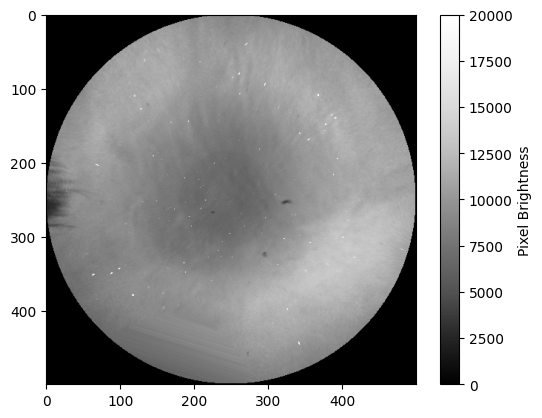

In [6]:
with h5py.File(filename, 'r') as h5:
    image = h5['ImageData'][:]

c = plt.imshow(image[0], vmin=0, vmax=20000, cmap='Greys_r')
plt.colorbar(c, label='Pixel Brightness')

### Mask
The corners of the image array are outside the minimum elevation set for processed data (ususally 15 degrees).  To reduce the volume of data files, the image array is saved as unsigned integers rather than floats, so these regions are set to zero rather than NaN (NaN is not a valid value for integer types).

It is often preferable to replace the masked regions with NaNs before any plotting or analysis.  The datafiles include a boolean mask array that can be used for this purpose.  Note that the image array must be cast to a float type first.


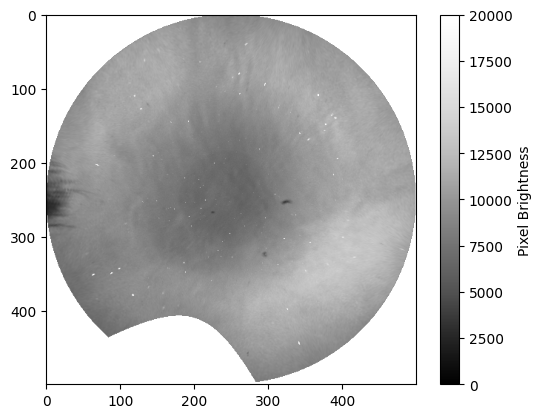

In [7]:
# Read in data
with h5py.File(filename, 'r') as h5:
    image = h5['ImageData'][:]
    mask = h5['Mask'][:]

# Set mask
image = image.astype(float)
image[:,mask] = np.nan

# Plot
c = plt.imshow(image[0], vmin=0, vmax=20000, cmap='Greys_r')
# plt.imshow(mask, alpha=0.3)
plt.colorbar(c, label='Pixel Brightness')

## Image Coordinates
Coordinates for each pixel in the image array are provided in the `Coordinates` field in several coordinate systems.  For each of these, coordinates are provided in 500 x 500 arrays to match the image shape and can be applied uniformly to all times in the image array.

### Pixel Coordinates
Pixel coordinaes represent the location of each pixel in kilometers East-West and North-South of the site.  These coordinates are most useful for flat visualizations where you would like to get an accurate view of spatial scale, and for any spatial analysis.

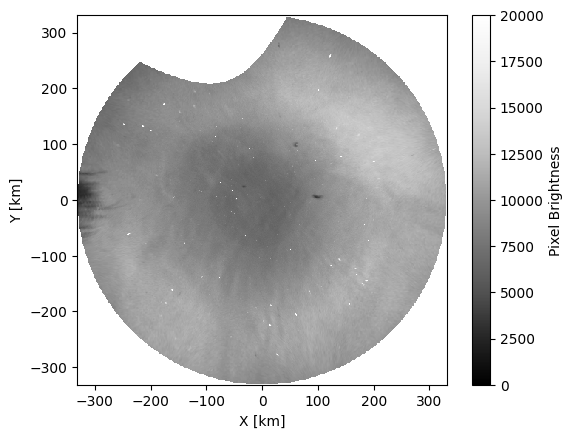

In [8]:
with h5py.File(filename, 'r') as h5:
    coords = h5['Coordinates/PixelCoordinates'][:]

fig, ax = plt.subplots()
c = ax.pcolormesh(coords[0], coords[1], image[0], vmin=0, vmax=20000, cmap='Greys_r')
ax.set_aspect('equal')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
fig.colorbar(c, label='Pixel Brightness')
plt.show()

### Geodetic Coordinates
When plotting geodetic latitude and longitude, images from more northern sites may appear warped.  These can also be used to superimpose the image on a map.

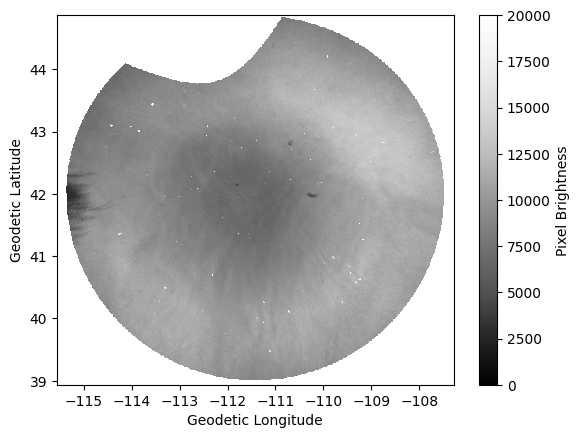

In [9]:
with h5py.File(filename, 'r') as h5:
    glat = h5['Coordinates/Latitude'][:]
    glon = h5['Coordinates/Longitude'][:]
    site_coords = h5['SiteInfo/Coordinates'][:]
    
fig, ax = plt.subplots()
c = ax.pcolormesh(glon, glat, image[0], vmin=0, vmax=20000, cmap='Greys_r')
ax.set_xlabel('Geodetic Longitude')
ax.set_ylabel('Geodetic Latitude')
fig.colorbar(c, label='Pixel Brightness')
plt.show()

Geodetic coordinates can also be used to superimpose the image on a map.

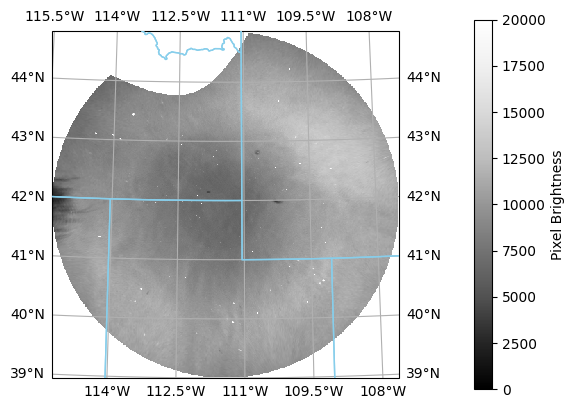

In [10]:
# Set up map
proj = ccrs.Orthographic(central_latitude=site_coords[0], central_longitude=site_coords[1])
fig, ax = plt.subplots(subplot_kw={'projection':proj})
ax.gridlines(draw_labels=True, zorder=3)
ax.add_feature(feature.COASTLINE)
ax.add_feature(feature.STATES, zorder=5, edgecolor='skyblue')

c = ax.pcolormesh(glon, glat, image[0], vmin=0, vmax=20000, cmap='Greys_r', transform=ccrs.PlateCarree())
fig.colorbar(c, pad=0.15, label='Pixel Brightness')
plt.show()

### Magnetic Coordinates
To reduce output file size, the positions of pixels in magnetic coordinates are not saved.  These can be caculated from the geodetic coordinates provided with a variety of magnetic conversion modules.  The following uses [apexpy](https://apexpy.readthedocs.io/en/latest/).  Note that if you convert longitude to magnetic local time, the grid will change for each time record in the file.

In [11]:
### Put in script for MLT conversion here

### Azimuth/Elevation
You typically would not plot an image in terms of azimuth and elevation, but these grids can be useful for other calculations or to limit analysis to a region near zenith or a particular sky direction.

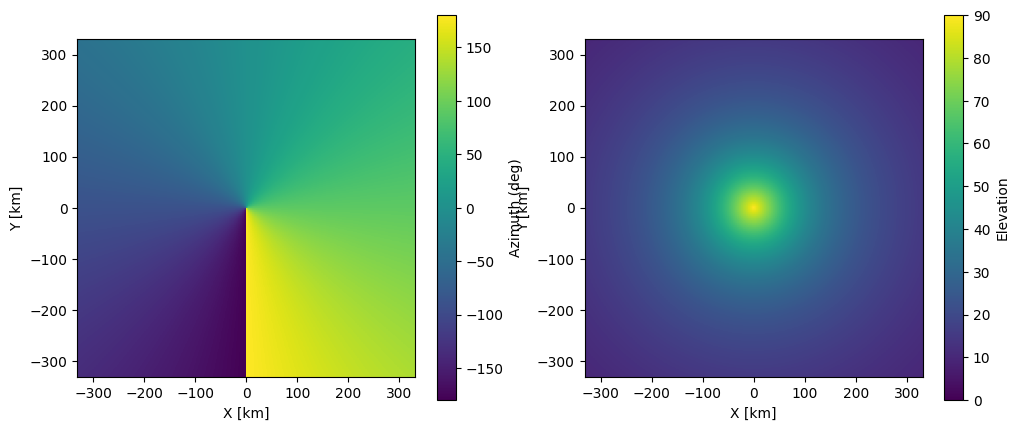

In [12]:
with h5py.File(filename, 'r') as h5:
    azmt = h5['Coordinates/Azimuth'][:]
    elev = h5['Coordinates/Elevation'][:]

# # Set mask to clarify plotting
# azmt[mask] = np.nan
# elev[mask] = np.nan

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

c = ax1.pcolormesh(coords[0], coords[1], azmt, vmin=-180, vmax=180, zorder=1)
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_aspect('equal')
fig.colorbar(c, label='Azimuth (deg)')

c = ax2.pcolormesh(coords[0], coords[1], elev, vmin=0, vmax=90, zorder=1)
ax2.set_xlabel('X [km]')
ax2.set_ylabel('Y [km]')
ax2.set_aspect('equal')
fig.colorbar(c, label='Elevation')

## Background
Background is calculated from the raw images by averaging the pixel values in the dark corners of the CCD outside the lens field of view.  This background is subtracted from the processed images by default, but the background timeseries is stored in the processed data files.

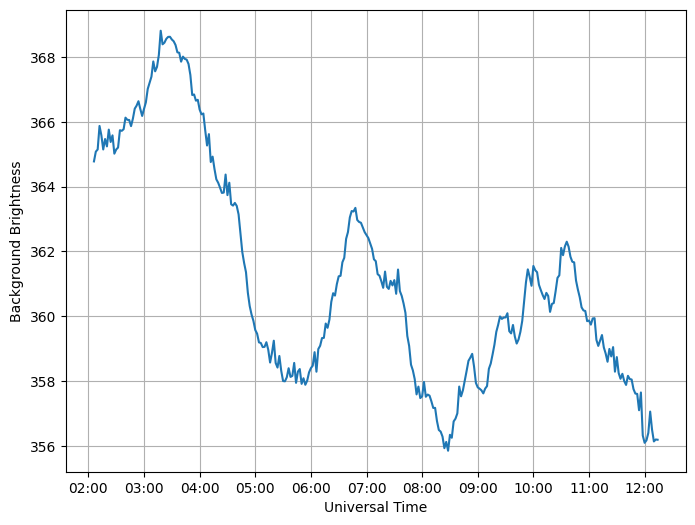

In [13]:
with h5py.File(filename, 'r') as h5:
    background = h5['Background'][:]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time, background)
ax.set_xlabel('Universal Time')
ax.set_ylabel('Background Brightness')
ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

The background can be re-added to the processed image array if you would like to do custom processing of the images, but this would be an atypical use case.

In [14]:
# Add background to images
image_with_background = image + background[:,None,None]

print('Original image:', image.shape)
print('Image with background added:', image_with_background.shape)

Original image: (305, 500, 500)
Image with background added: (305, 500, 500)


## Atmospheric Corrections
The airglow intensity observed from the ground is impacted by the atmosphere, usually as a function of zenith angle ($\theta$).  There are some standard corrections that can be applied to airglow imagery [Kubota2001].

### Van Rhijn Effect
The van Rhijn correction factor accounts for the fact that the airglow intensity should be proportional to the length of the line of sight in the emission layer [Tohmatsu1990].

$$ I = I_0 \left[1-\left(\frac{R_E}{R_E+h_a}\right)^2\sin^2\theta\right]^{-\frac{1}{2}} $$

### Atmospheric Extinction

Atmospheric extintion is the scatering and absorption of airglow emissions in the atmosphere [Kasten1966].

$$ F(\theta) = \left[\cos\theta + 0.15(93.885-\theta_d)^{-1.253}\right]^{-1} $$
Here, $\theta_d$ is $\theta$ explicitly expressed in degrees.
$$ I = I_0 e^{-aF(\theta)} $$
The factor $a$ is the atmospheric extinction coeffienent and varies with condition, usually between 0.2 and 0.4.

The product of these two correction factors is plotted below, showing how the intensity observed on the ground should vary from the true intensity of the airglow emissions.

Text(0, 0.5, '$I_{obs}/I_0$')

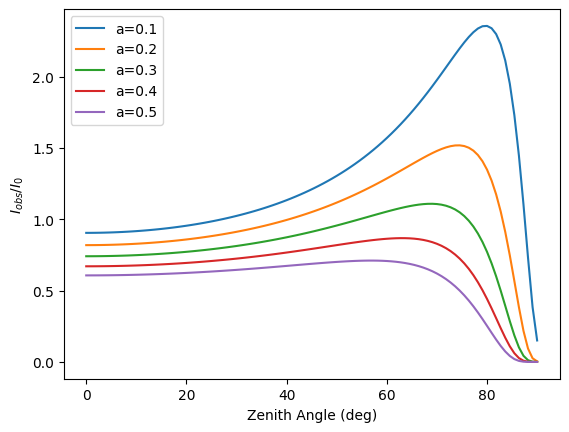

In [15]:
RE = 6371.
ha = 97.
za = np.linspace(0., np.pi/2., 100)

fig, ax = plt.subplots()

for a in [0.1, 0.2, 0.3, 0.4, 0.5]:
    # van Rhijn effect
    vrf = 1.0 / np.sqrt(1.0 - np.sin(za) ** 2 * (RE / (RE + ha)) ** 2)
    # atmospheric extinction
    F = 1.0 / (np.cos(za) + 0.15 * (93.885 - np.rad2deg(za)) ** (-1.253))
    exf = np.exp(-a*F)
    # Plot    
    ax.plot(np.rad2deg(za), vrf*exf, label=f'a={a}')
    
ax.legend()
ax.set_xlabel('Zenith Angle (deg)')
ax.set_ylabel(r'$I_{obs}/I_0$')


To correct for these atmospheric effects and estimate the true brightness of the airglow layer ($I_0$), multiply the pixel brightness by the an elevation-dependent factor.

$$ I_0 = I_{obs}e^{aF(\theta)}\sqrt{1-\left(\frac{R_E}{R_E+h_a}\right)^2\sin^2\theta} $$


Text(0.5, 1.0, 'Corrected Image')

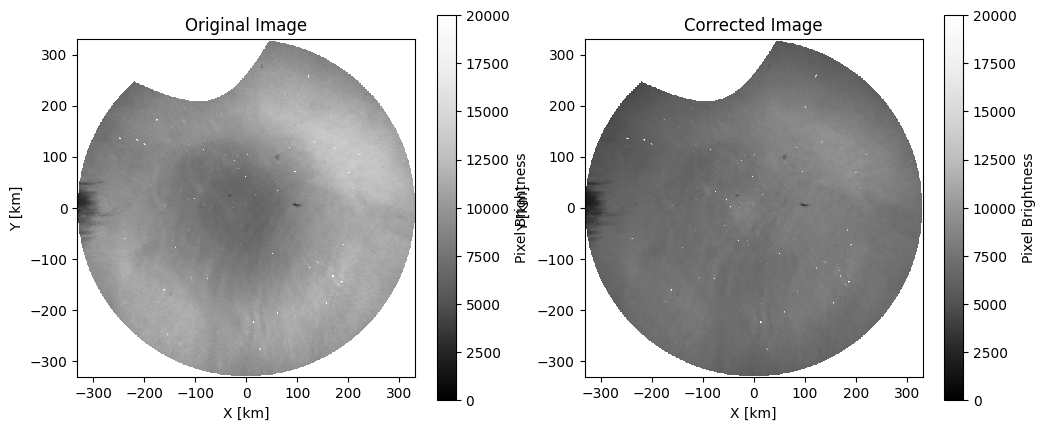

In [16]:
RE = 6371.

# Read elevation angle and hight of airglow layer from file
with h5py.File(filename, 'r') as h5:
    elev = h5['Coordinates/Elevation'][:]
    ha = h5['ProcessingInfo/Altitude'][()]

# calculate zenith angle
za = np.pi / 2 - elev * np.pi / 180.0

# Kubota et al., 2001; eqn. 6
vanrhijn_factor = np.sqrt(1.0 - np.sin(za) ** 2 * (RE / (RE + ha)) ** 2)

# Kubota et al., 2001; eqn. 7,8
a = 0.2
F = 1.0 / (np.cos(za) + 0.15 * (93.885 - za * 180.0 / np.pi) ** (-1.253))
extinction_factor = np.exp(a * F)
# extinction_factor = 10.0 ** (0.4 * a * F)

image_corr = image * vanrhijn_factor * extinction_factor

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

c = ax1.pcolormesh(coords[0], coords[1], image[0], vmin=0, vmax=20000, cmap='Greys_r')
ax1.set_aspect('equal')
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
fig.colorbar(c, label='Pixel Brightness')
ax1.set_title('Original Image')

c = ax2.pcolormesh(coords[0], coords[1], image_corr[0], vmin=0, vmax=20000, cmap='Greys_r')
ax2.set_aspect('equal')
ax2.set_xlabel('X [km]')
ax2.set_ylabel('Y [km]')
fig.colorbar(c, label='Pixel Brightness')
ax2.set_title('Corrected Image')

## Data Quality
The `DataQuality` field in the processed data file contains information that may be useful for determining if a particular image can be trusted for analysis.

The CCDs on MANGO imagers are cooled and the temperature is reported in `CCDTemperature`.  Higher values may indicate that the image will be noisy.

Moon position and phase are often the most significant factors in whether or not an optical image can be used as the moon can be a very bright object that overwhelms any airglow emissions.  The moon azimuth (`MoonAzimuth`) and elevation (`MoonElevation`) angles are given for each record in the night.  Additionally, the moon phase (`MoonPhase`) is given in degrees with new moon at 0 degrees and full moon at 180 degrees.  The phase of the moon changes very little over the course of a single night, so it may be more practically useful to take the average of this field.  Typically a combination of moon phase and elevation can be used to filter out any times with moon contamination.


Average Moon Phase: 30.277218925545483


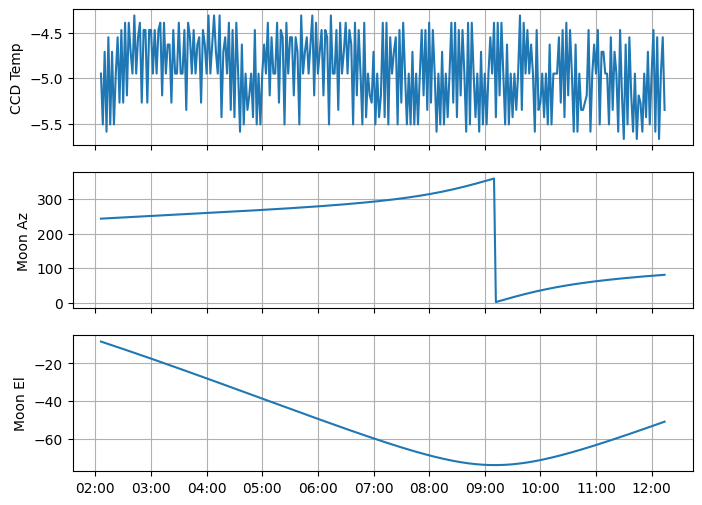

In [17]:
with h5py.File(filename, 'r') as h5:
    ccdtemp = h5['DataQuality/CCDTemperature'][:]
    moonaz = h5['DataQuality/MoonAzimuth'][:]
    moonel = h5['DataQuality/MoonElevation'][:]
    moonphase = h5['DataQuality/MoonPhase'][:]

print('Average Moon Phase:', np.mean(moonphase))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,6))
ax1.plot(time, ccdtemp)
ax1.set_xticklabels([])
ax1.set_ylabel('CCD Temp')
ax1.grid()
ax2.plot(time, moonaz)
ax2.set_xticklabels([])
ax2.set_ylabel('Moon Az')
ax2.grid()
ax3.plot(time, moonel)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.set_ylabel('Moon El')
ax3.grid()


## Keograms
Keograms can be generated from the `ImageData` array by taking an approprate horizontal or vertical slice and plotting against time and the appropriate coordinate.  This example shows and N-S keogram taken from the center of the imager field of view.

Text(0, 0.5, 'Geodetic Latitude')

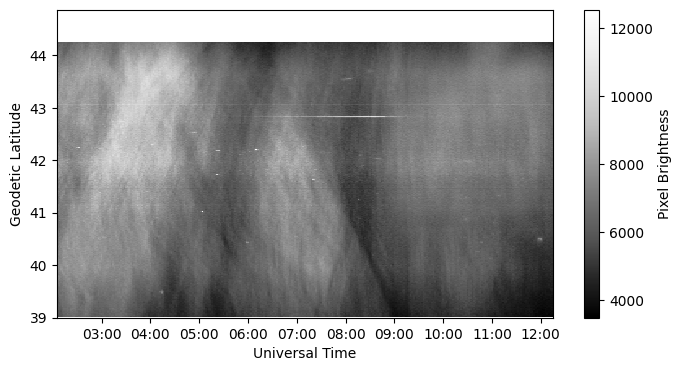

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
c = ax.pcolormesh(time, glat[:,250], image_corr[:,:,250].T, cmap='Greys_r')
fig.colorbar(c, label='Pixel Brightness')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Universal Time')
ax.set_ylabel('Geodetic Latitude')

## Generate movie of images for a night

## Filter to make waves apparent